# Classification method for FX Volatility Risk Premia

This notebook presents a classification method for FX Volatility Risk Premia. The goal is to develop a model that can predict the spread between implied and realized volatility for various currency pairs. The notebook includes data preprocessing, feature engineering, model training, and evaluation steps. Various machine learning techniques are employed to achieve the best possible predictive performance.

In [3]:
import pandas as pd
import numpy as np
import shap
import datetime as dt
import cufflinks as cf
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from boruta import BorutaPy

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    GridSearchCV, 
                                    TimeSeriesSplit, 
                                    cross_val_score,
                                    RandomizedSearchCV,
                                    cross_val_predict
                                    )
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, fbeta_score, make_scorer,
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
                            mean_squared_error, accuracy_score)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import warnings

from vol_estimates import parkinson, rodgers_satchell, garman_klass, yang_zhang

warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use('ggplot')
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
def rolling_z(price_data, window=30, standardize=True):
    if standardize:
        z_scores = (price_data - price_data.rolling(window, min_periods=window).mean()) \
            / price_data.rolling(window, min_periods=window).std()
    else:
        z_scores = price_data / price_data.rolling(window, min_periods=window).std()
    return z_scores

def data_flat(X):
    X_flat = pd.DataFrame()
    selected_features = set([f[:-4] for f in X.columns if f[-3:] != 'all'])
    selected_currencies = set([f[-3:] for f in X.columns if f[-3:] != 'all'])
    common_features = [f[:-4] for f in X.columns if f[-3:] == 'all']
    for f in selected_features:
        X_flat[f] = X.filter(regex='^'+f).to_numpy(na_value=np.nan).flatten(order='C')
    for f in common_features:
        X_flat[f] = np.repeat(X[f+'_all'].to_numpy(na_value=np.nan), len(selected_currencies))
    return X_flat

def plot_contours(ax, clf, xx, yy, **params):
    Z = (clf.decision_function(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Data Description and Preparation

The data used in this notebook includes FX spot rates, FX volatility, indices, and interest rates for various currency pairs. The primary goal is to predict the spread between implied and realized volatility.

1. **Data Sources**:
    - `FXSpot.csv`: Contains FX spot rates.
    - `FXVol.csv`: Contains FX volatility data.
    - `Index.csv`: Contains index data.
    - `Rates.csv`: Contains interest rate data.

2. **Data Preprocessing**:
    - The data is read from CSV files and forward-filled to handle missing values.
    - Returns are calculated for each currency pair.
    - Realized and implied volatilities are computed.
    - Various features are engineered, including exponential weighted moving averages, rolling means, and volatility estimates using different methods (e.g., Parkinson, Garman-Klass, Rogers-Satchell, Yang-Zhang).
    - The features are then combined and ranked on a percentile basis to create the final feature set.

3. **Feature Selection**:
    - Selected features include percentile ranks of spreads between realized and implied volatilities and implied ATM volatilities.
    - The data is split into training and testing sets, and further flattened for model training.

This comprehensive data preparation ensures that the machine learning models have a robust set of features to learn from and make accurate predictions.
```

In [5]:
ccies = ['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF']
strong = ['EUR', 'GBP', 'AUD', 'NZD']

df_spot = pd.read_csv('FXSpot.csv', index_col=0, parse_dates=True).sort_index()
df_vol = pd.read_csv('FXVol.csv', index_col=0, parse_dates=True).sort_index()
df_indices = pd.read_csv('Index.csv', index_col=0, parse_dates=True).sort_index()
df_rates = pd.read_csv('Rates.csv', index_col=0, parse_dates=True).sort_index()

In [6]:
df_spot.ffill(inplace=True)
df_vol.ffill(inplace=True)
df_indices.ffill(inplace=True)
df_rates.ffill(inplace=True)

In [7]:
df_returns = pd.DataFrame(index=df_spot.index.unique(), columns=ccies)
for c in ccies:
    df = df_spot[df_spot['security'] == c + ' CMP Curncy']['PX_LAST']
    df_returns[c] = df.pct_change()
idx = pd.date_range(end=df_vol.index[-1], start = df_vol.index[0], freq='BM')
realised_vol = pd.DataFrame(index=idx, columns=ccies)
implied_vol = pd.DataFrame(index=idx, columns=ccies)
for i, d in enumerate(idx[:-1]):
    for ccy in ccies:
        realised_vol[ccy].loc[d] = np.sqrt(260) * (df_returns.loc[d:idx[i+1], ccy]).std()
        if ccy in strong:
            implied_vol[ccy].loc[d] = df_vol.loc[d, ccy + 'USDV1M CMP Curncy']
        else:
            implied_vol[ccy].loc[d] = df_vol.loc[d, 'USD' + ccy + 'V1M CMP Curncy']

In [8]:
raw_features = pd.DataFrame(index=df_vol.index)

raw_features = raw_features.merge(df_indices.add_suffix('_all'), on='date')

window = 22
day_count = 260

vol = np.sqrt(day_count * (df_returns ** 2).ewm(alpha=0.03, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ewm_'), on='date')
vol = np.sqrt(day_count * (df_returns ** 2).rolling(window=window, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ctc_'), on='date')

for ccy in ccies:
    if ccy in strong:
        atm = df_vol[ccy + 'USDV1M CMP Curncy']
        rr = df_vol[ccy + 'USD25R1M CMP Curncy']
        bf = df_vol[ccy + 'USD25B1M CMP Curncy']
    else:
        atm = df_vol['USD' + ccy + 'V1M CMP Curncy']
        rr = df_vol['USD' + ccy + '25R1M CMP Curncy']
        bf = df_vol['USD' + ccy + '25B1M CMP Curncy']
    raw_features['implied_atm_'+ccy] = atm
    #raw_features['implied_skew_'+ccy] = (rr) / atm
    #raw_features['implied_kurt_'+ccy] = (bf) / atm
    ohlc = df_spot[df_spot['security'] == ccy + ' CMP Curncy'][['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST']]
    ohlc.columns = ['Open', 'High', 'Low', 'Close']
    rate_diff = df_rates['GT'+ccy+'2Y Govt'] - df_rates['GT2 Govt']
    #raw_features['rate_diff_vol_'+ccy] = np.sqrt(day_count * (rate_diff ** 2).rolling(window=window, min_periods=window).mean())
    for e,p in zip(['par', 'gk', 'rs', 'yz'], [parkinson, garman_klass, rodgers_satchell, yang_zhang]):
        raw_features['realised_'+e+'_'+ccy] = p(ohlc, window=window, day_count=day_count)
    raw_features['spot_range_'+ccy] = (ohlc['High'] - ohlc['Low']).rolling(window=window, min_periods=window).mean()
    


In [9]:
atm_col = ['implied_atm_'+ccy for ccy in ccies]
spreads = pd.DataFrame(index=raw_features.index, columns=raw_features.filter(regex='realised').columns)
for e in ['ctc', 'ewm', 'par', 'gk', 'rs', 'yz']:
    realised_col = ['realised_'+e+'_'+ccy for ccy in ccies]
    spreads[realised_col] = np.log(raw_features[atm_col].values/(100*raw_features[realised_col]).values)
spreads = spreads.add_prefix('spread_')

In [10]:
features = pd.concat([raw_features, spreads], axis=1)
window = 260
features = pd.concat([
    features,
    features.rolling(window=window, min_periods=window).rank(pct=True).add_prefix('pct_')
    ], axis=1)

In [11]:
selected_features = ['pct_spread_realised_ewm', 'pct_implied_atm']
y = (implied_vol - 100 * realised_vol).dropna()
X = pd.concat([features.filter(regex=f) for f in selected_features], axis=1).dropna() #.shift(1) #may go here or better later in backtest
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_flat = data_flat(X_train)
X_test_flat = data_flat(X_test)
y_train_flat = pd.Series(y_train[ccies].to_numpy().flatten(order='C'))
y_test_flat = pd.Series(y_test[ccies].to_numpy().flatten(order='C'))
print('Train Set: %s to %s' % (str(X_train.index[0].date()), str(X_train.index[-1].date())))
print('Test Set: %s to %s' % (str(X_test.index[0].date()), str(X_test.index[-1].date())))

Train Set: 2001-01-31 to 2019-04-30
Test Set: 2019-05-31 to 2023-12-29


## Feature Binning and Visualization

In this section, we bin the features `pct_implied_atm` and `pct_spread_realised_ewm` into discrete intervals and visualize the average target values within these bins. This helps us understand the relationship between the binned features and the target variable.

1. **Binning Features**:
    - We create bins for the features `pct_implied_atm` and `pct_spread_realised_ewm` using `np.linspace` to generate evenly spaced intervals.
    - The `pd.cut` function is used to bin the features into these intervals and assign labels to the bins.

2. **Visualization**:
    - We create bar plots to visualize the average target values within each bin for both `pct_implied_atm` and `pct_spread_realised_ewm`.
    - A heatmap is generated to show the average target values for the combination of binned `pct_implied_atm` and `pct_spread_realised_ewm`.

These visualizations provide insights into how the binned features relate to the target variable, which can be useful for feature engineering and model interpretation.

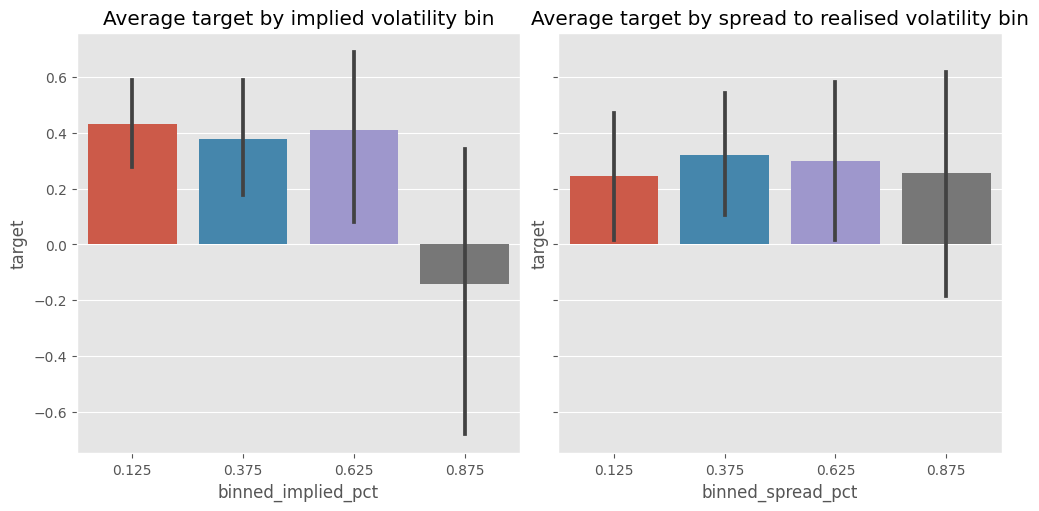

In [10]:
bins = np.linspace(0, 1, 5)
labels = bins[:-1] + np.diff(bins)/2
agg_values = pd.DataFrame(y_train_flat, columns=['target'])
agg_values['binned_implied_pct'] = pd.cut(X_train_flat['pct_implied_atm'], bins, labels=labels, include_lowest=True)
agg_values['binned_spread_pct'] = pd.cut(X_train_flat['pct_spread_realised_ewm'], bins, labels=labels, include_lowest=True)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5), constrained_layout=True)
sns.barplot(x='binned_implied_pct', y='target', data=agg_values, ax=ax[0])
sns.barplot(x='binned_spread_pct', y='target', data=agg_values, ax=ax[1])
ax[0].set_title('Average target by implied volatility bin')
ax[1].set_title('Average target by spread to realised volatility bin')
fig.show()

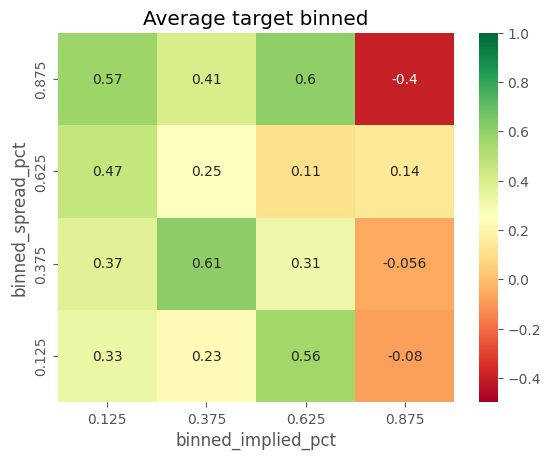

In [11]:
ax = sns.heatmap(pd.pivot_table(
    agg_values.astype(float),
    values='target',
    columns= agg_values['binned_implied_pct'], index=agg_values['binned_spread_pct'], aggfunc=np.mean),
    cmap='RdYlGn', vmin=-0.5, vmax=1, annot=True)
ax.invert_yaxis()
ax.set_title('Average target binned')
plt.show()

## Model Training and Evaluation

In this section, we will train and evaluate a Support Vector Machine (SVM) model using the preprocessed data. The steps include:

1. **Threshold Setting**:
    - We set a threshold to classify the target variable into binary classes (positive and negative labels).

2. **Custom Scoring Function**:
    - We define a custom scoring function using the F-beta score with beta set to 1/4. This scoring function will be used to evaluate the model's performance during cross-validation.

3. **Cross-Validation and Hyperparameter Tuning**:
    - We use TimeSeriesSplit for cross-validation to ensure that the model is evaluated on different time periods.
    - We define a pipeline with an SVM classifier and perform a grid search to find the best hyperparameters for the SVM model.

4. **Model Training**:
    - We train the SVM model using the best hyperparameters found during the grid search.
    - We evaluate the model's performance on the training set and display the classification report and confusion matrix.

5. **Decision Function Threshold**:
    - We calculate the decision function threshold based on the 25th percentile of the positive decision function values. This threshold will be used to classify the test set.

These steps ensure that the SVM model is trained and evaluated effectively, with the best possible hyperparameters and a custom scoring function tailored to the problem at hand.

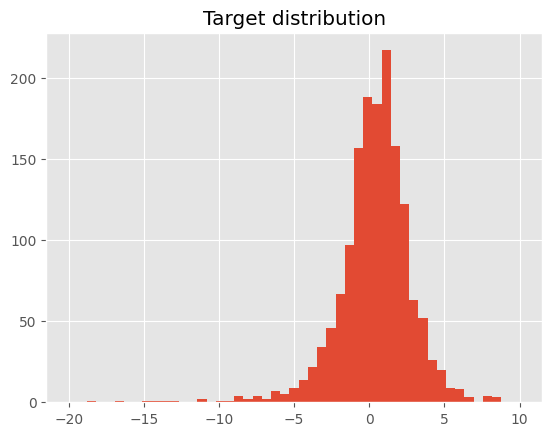

Median target: 0.55
Mean target: 0.28
Target std: 3.09
Thresold for positive label: 0.50
Train Set positive lables: 786 out of 1540


In [24]:
plt.hist(y_train_flat, bins=np.linspace(-20, 10, 50))
plt.title('Target distribution')
plt.show()
print('Median target: %.2f' % y_train_flat.median())
print('Mean target: %.2f' % y_train_flat.mean())
print('Target std: %.2f' % y_train_flat.std())
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
print('Threshold for positive label: %.2f' % threshold)
print("Train Set positive lables: %d out of %d" % (labels_train.sum(), len(labels_train)))
labels_test = (y_test_flat > threshold).astype(int)

In [15]:
fb_score = make_scorer(fbeta_score, beta=(1/4))

In [16]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [{'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5, 10.0],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring=fb_score)
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'svm__C': 2.5, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}

Tuned model:
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       754
           1       0.53      0.67      0.60       786

    accuracy                           0.53      1540
   macro avg       0.53      0.53      0.52      1540
weighted avg       0.53      0.53      0.52      1540



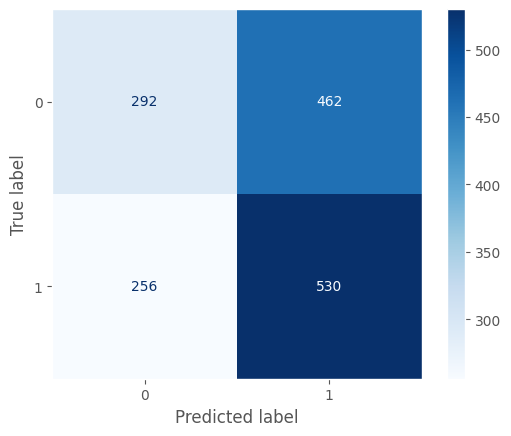

In [17]:
pipeline = Pipeline([
    ('svm', SVC(C=2.5, gamma='auto', kernel='rbf'))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

In [18]:
des_vector = pipeline.decision_function(X_train_flat)
des_th = np.percentile(des_vector[des_vector > 0], 25)

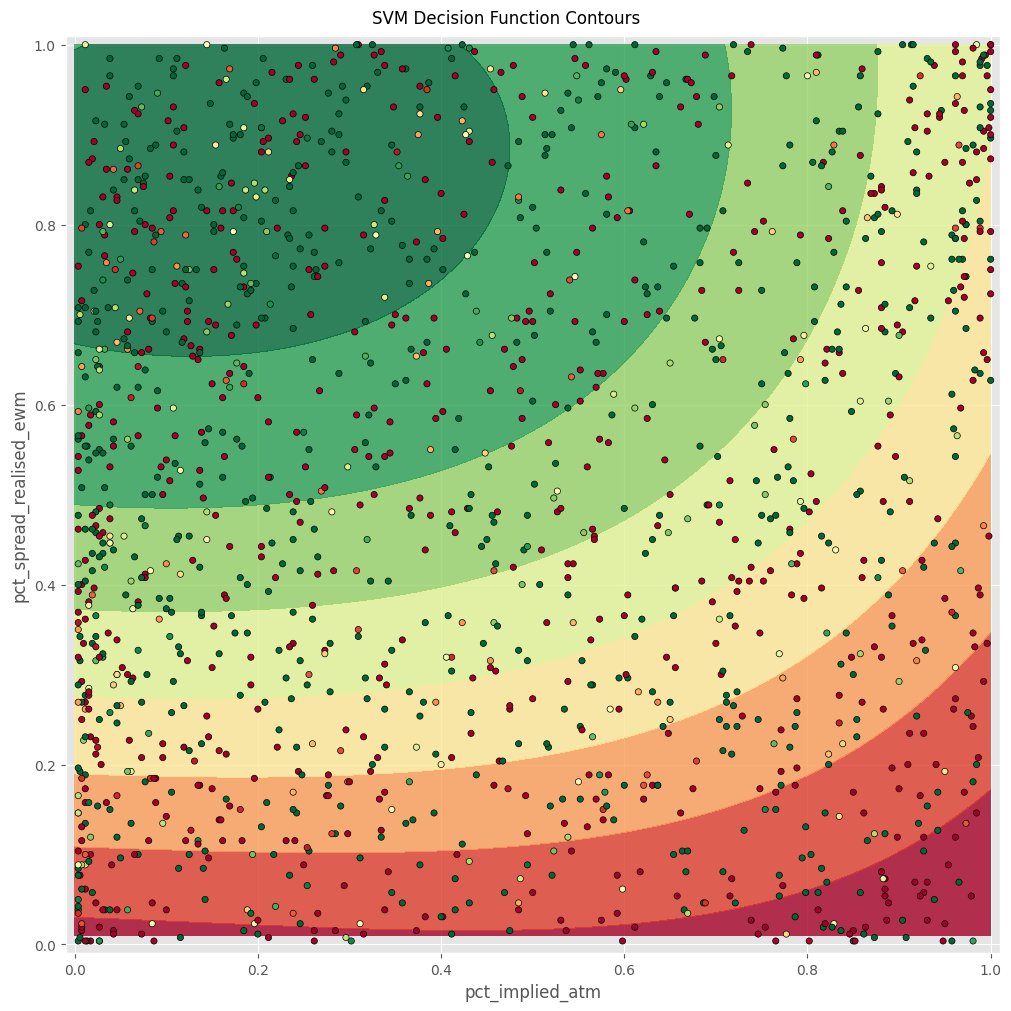

In [19]:
xx, yy = np.meshgrid(np.arange(0,1.01,0.01), np.arange(0.01,1.01,0.01))
fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)
plot_contours(ax, pipeline, xx, yy, cmap='RdYlGn', vmin=-1, vmax=1, alpha=0.8)
ax.scatter(X_train_flat.iloc[:,0], X_train_flat.iloc[:,1],
        c=y_train_flat, cmap='RdYlGn', vmin=0, vmax=1, s=20, edgecolors='k')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
ax.xaxis.set_label_text(X_train_flat.columns[0])
ax.yaxis.set_label_text(X_train_flat.columns[1])
fig.suptitle('SVM Decision Function Contours')
fig.show()

## Classification Report for the Test Set

In [20]:
print(classification_report(labels_test, pipeline.decision_function(X_test_flat)>des_th))

              precision    recall  f1-score   support

           0       0.60      0.55      0.58       217
           1       0.48      0.52      0.50       168

    accuracy                           0.54       385
   macro avg       0.54      0.54      0.54       385
weighted avg       0.55      0.54      0.54       385



## Trading Strategy based on the Model Predictions

### In-sample Performance

         Sharpe Ratio
Naive            0.71
SVM              1.12
Uniform          0.46
LS               0.74


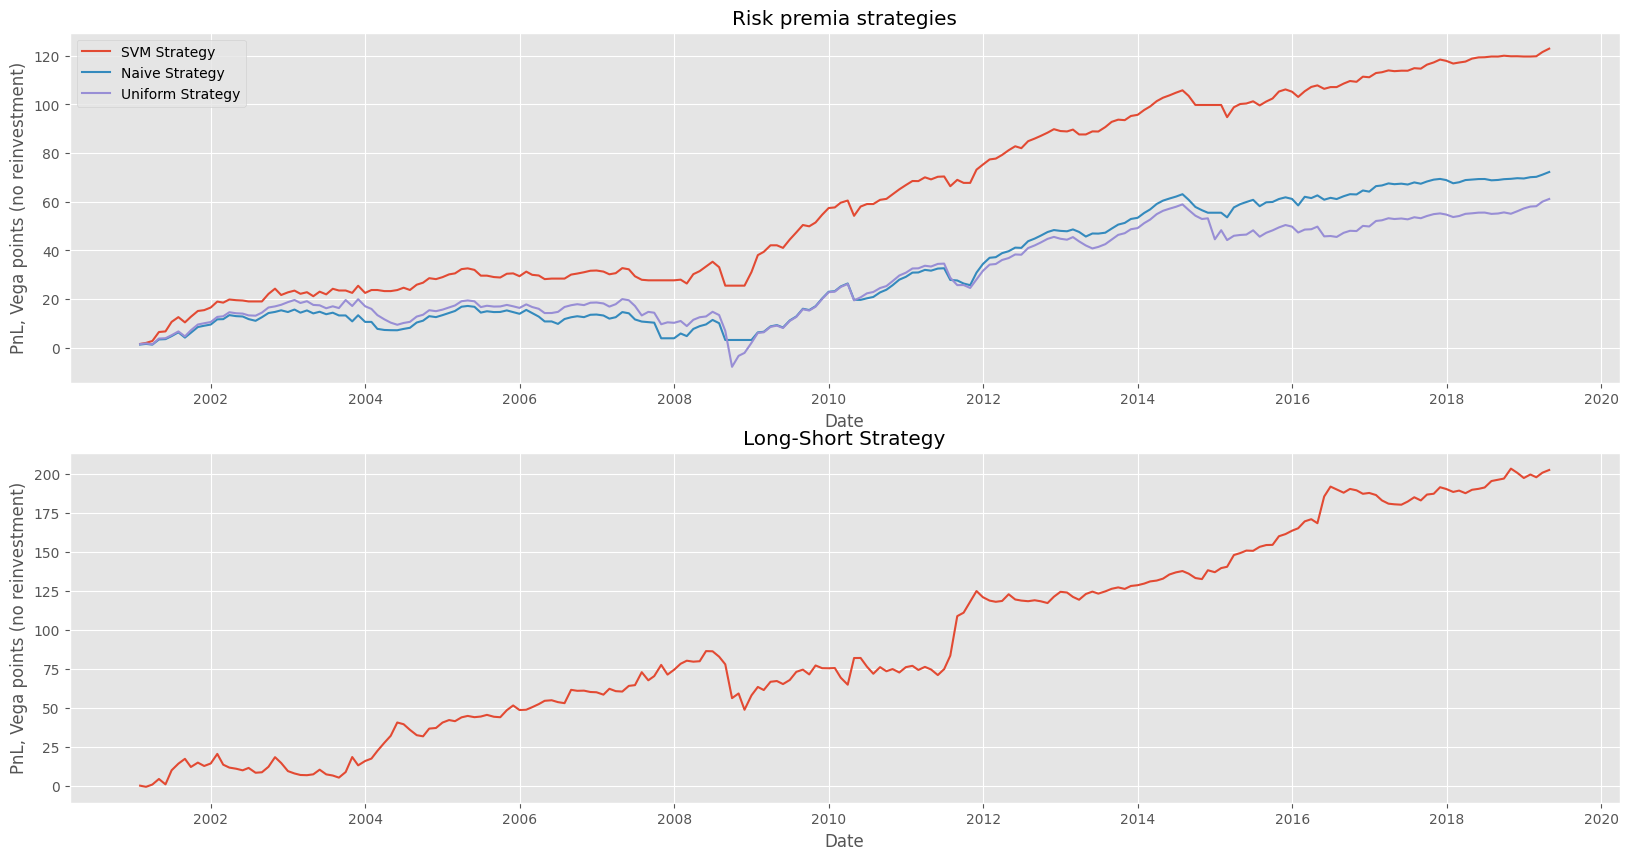

In [19]:
selected_features = X_train_flat.columns
features_data = pd.concat([features.filter(regex='^'+f) for f in selected_features], axis=1).loc[y_train.index]
signal_ml = pd.DataFrame(index=y_train.index, columns=ccies)
signal_naive = pd.DataFrame(index=y_train.index, columns=ccies)
des_f = pd.DataFrame(index=y_train.index, columns=ccies)
for ccy in ccies:
    c = [f + '_' + ccy for f in selected_features]
    signal_ml[ccy] = (pipeline.decision_function(features_data[c].to_numpy()) > des_th).astype(int)
    signal_naive[ccy] = (features_data['pct_implied_atm_'+ccy] <= 0.75).astype(int)
    des_f[ccy] = pipeline.decision_function(features_data[c].to_numpy())
pos_ml = signal_ml.div(signal_ml.sum(axis=1), axis=0).fillna(0)
pnl_ml = (pos_ml * y_train).sum(axis=1)
pnl_uniform = (y_train.mean(axis=1))
pos_naive = signal_naive.div(signal_naive.sum(axis=1), axis=0).fillna(0)
pnl_naive = (pos_naive * y_train).sum(axis=1)
ls_position = (des_f.rank(axis=1) >= (len(des_f.columns) - 1)).astype(int) - (des_f.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_train).sum(axis=1)
sharpe = pd.DataFrame(index=['Naive', 'SVM', 'Uniform', 'LS'], columns=['Sharpe Ratio'])
sharpe['Sharpe Ratio'] = [np.sqrt(12)*pnl.mean()/pnl.std() for pnl in [pnl_naive, pnl_ml, pnl_uniform, ls_pnl]]
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(sharpe)

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(pnl_ml.cumsum(), label='SVM Strategy')
ax[0].plot(pnl_naive.cumsum(), label='Naive Strategy')
ax[0].plot(pnl_uniform.cumsum(), label='Uniform Strategy')
ax[0].set_title('Risk premia strategies')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
ax[1].set_title('Long-Short Strategy')
ax[1].plot(ls_pnl.cumsum(), label='Long-Short SVM Strategy')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
fig.show()

### Out-of-sample Performance

         Sharpe Ratio
Naive           -0.06
SVM              1.52
Uniform         -0.03
LS               0.69


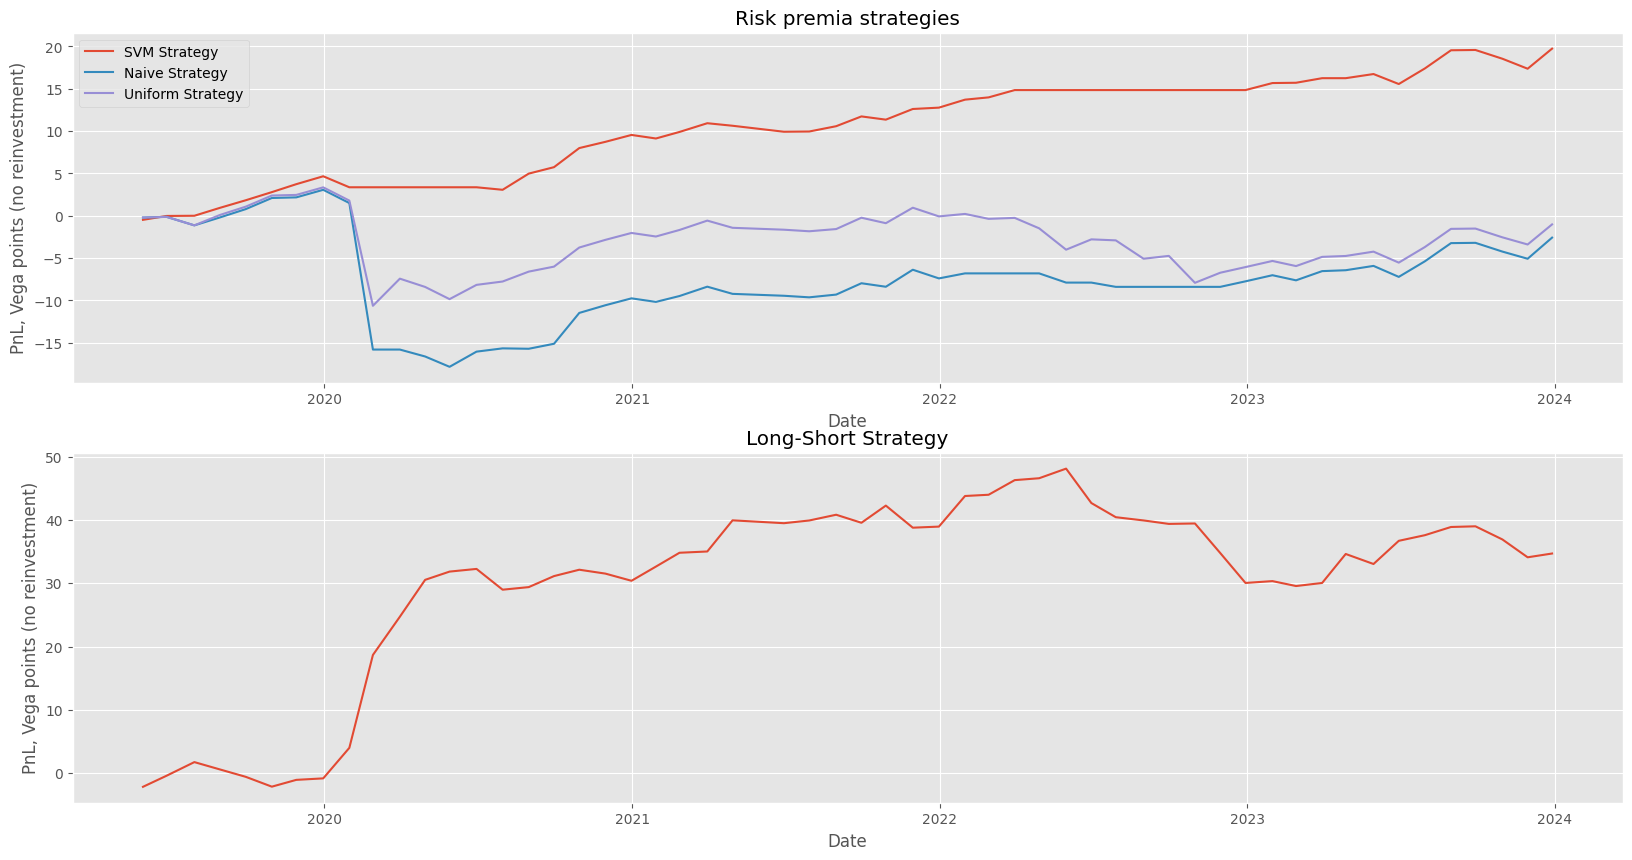

In [20]:
features_data = pd.concat([features.filter(regex='^'+f) for f in selected_features], axis=1).shift(0).loc[y_test.index]
signal_ml = pd.DataFrame(index=y_test.index, columns=ccies)
signal_naive = pd.DataFrame(index=y_test.index, columns=ccies)
des_f = pd.DataFrame(index=y_test.index, columns=ccies)
for ccy in ccies:
    c = [f + '_' + ccy for f in selected_features]
    signal_ml[ccy] = (pipeline.decision_function(features_data[c].to_numpy()) > des_th).astype(int)
    signal_naive[ccy] = (features_data['pct_implied_atm_'+ccy] <= 0.75).astype(int)
    des_f[ccy] = pipeline.decision_function(features_data[c].to_numpy())
pos_ml = signal_ml.div(signal_ml.sum(axis=1), axis=0).fillna(0)
pnl_ml = (pos_ml * y_test).sum(axis=1)
pnl_uniform = (y_test.mean(axis=1))
pos_naive = signal_naive.div(signal_naive.sum(axis=1), axis=0).fillna(0)
pnl_naive = (pos_naive * y_test).sum(axis=1)
ls_position = (des_f.rank(axis=1) >= (len(des_f.columns) - 1)).astype(int) - (des_f.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_test).sum(axis=1)
sharpe = pd.DataFrame(index=['Naive', 'SVM', 'Uniform', 'LS'], columns=['Sharpe Ratio'])
sharpe['Sharpe Ratio'] = [np.sqrt(12)*pnl.mean()/pnl.std() for pnl in [pnl_naive, pnl_ml, pnl_uniform, ls_pnl]]
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(sharpe)

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(pnl_ml.cumsum(), label='SVM Strategy')
ax[0].plot(pnl_naive.cumsum(), label='Naive Strategy')
ax[0].plot(pnl_uniform.cumsum(), label='Uniform Strategy')
ax[0].set_title('Risk premia strategies')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
ax[1].set_title('Long-Short Strategy')
ax[1].plot(ls_pnl.cumsum(), label='Long-Short SVM Strategy')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
fig.show()